# Example notebook for generating masks for metasurfaces with pyMOE 

The following notebook exemplifies how to make a metasurface from a 2D phase mask - while it is for a Fresnel phase mask, in general any 2D phase can be used to obtain the metasurface mask. 

In [1]:
%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../..')
sys.path.insert(0,'../../..')

In [2]:
import pyMOE as moe 
import pyMOE.generate as gen 
import pyMOE.export as exp 

In [3]:
import numpy as np 
from scipy import interpolate
import matplotlib.pyplot as plt 

<IPython.core.display.Javascript object>


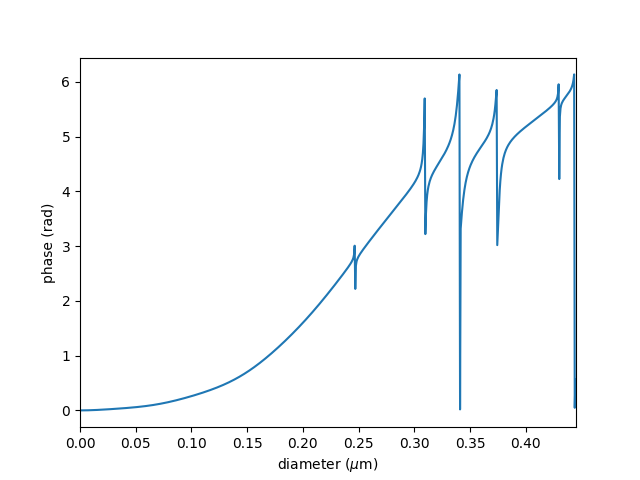

(0.0, 0.445)

In [4]:
###the curve of diameter of cylinder vs lattice const is imported  (here from RCWA calc)

dvar_cut = np.genfromtxt("dvar_638nm_p445nm.txt", delimiter=",")  
phas_cut = np.genfromtxt("phaserad_638nm_p445nm.txt", delimiter=",")  

#the periodicity 
p=0.445 # in um 

fig = plt.figure() 
plt.plot(dvar_cut, phas_cut)
plt.xlabel('diameter ($\mu$m)')
plt.ylabel('phase (rad)')
plt.xlim([0,p])
#np.max(dvar_cut)

In [5]:
from scipy import interpolate

#function that interpolates the phase difference curve 
#given a certain phase, will give us the diameter of the cylinders
func = interpolate.interp1d(phas_cut,dvar_cut, fill_value="extrapolate")

[-3.14145235e+00 -2.35617183e+00 -1.57089131e+00 -7.85610789e-01
 -3.30269813e-04  7.84950250e-01  1.57023077e+00  2.35551129e+00
  3.14079181e+00]


<IPython.core.display.Javascript object>


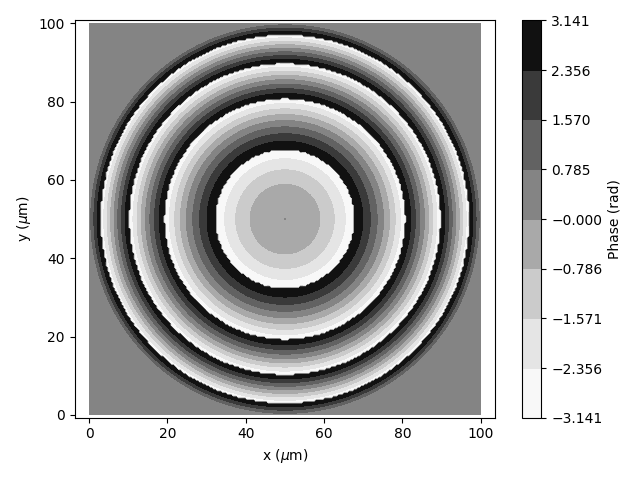

Passing contours into GDS. 
Saved the phase profile with 8 layers into the file fresnel_phase_mask.gds


In [6]:
foc = 500 # focal distance in um 
lda = 0.6328 #wavelength in um 
xsiz = 100 #um
ysiz = 100 #um
n = 8  # number of gray levels 
gdsname = 'fresnel_phase_mask.gds' # name of gds file

#TO CHECK, the number of pix seems not correct 

#calculation for the number of pixels using the size in x and the periodicity
npix = int(np.round(xsiz/p))

#obtain the phase profile of a fresnel phase mask 
fresarray_rad= moe.gen.fresnel_phase_mask(npix, foc, lda, xsiz, ysiz, n, filename=gdsname, plotting=True)


In [7]:
fresarray_rad.shape

(225, 225)

In [8]:
###transform the phase map into [0, 2*pi]
#Attention, fresarray_rad is the 2D phase map WITHOUT being layered -> exact phase value
fphas = fresarray_rad + np.pi

#transform the phase map into a map of the pillar diameters 
dvars = func(fphas)
dvars

array([[0.26153956, 0.26153956, 0.26153956, ..., 0.26153956, 0.26153956,
        0.26153956],
       [0.26153956, 0.26153956, 0.26153956, ..., 0.26153956, 0.26153956,
        0.26153956],
       [0.26153956, 0.26153956, 0.26153956, ..., 0.26153956, 0.26153956,
        0.26153956],
       ...,
       [0.26153956, 0.26153956, 0.26153956, ..., 0.26153956, 0.26153956,
        0.26153956],
       [0.26153956, 0.26153956, 0.26153956, ..., 0.26153956, 0.26153956,
        0.26153956],
       [0.26153956, 0.26153956, 0.26153956, ..., 0.26153956, 0.26153956,
        0.26153956]])

<IPython.core.display.Javascript object>


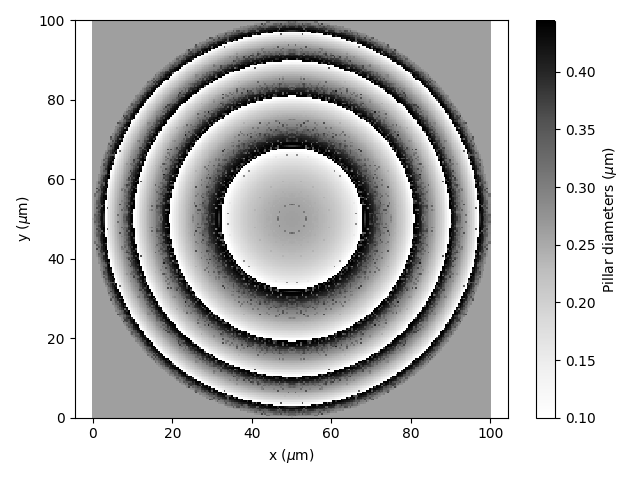

In [9]:
###Let's represent the map of the diameter of the cylinders
#clip the matrix of values within a range 
dvarx = np.clip(dvars,0.1,np.max(dvar_cut) )

#create the vectors for xsiz and ysiz, with npix 
xc1 = np.linspace(0, xsiz, npix)
yc1 = np.linspace(0, ysiz, npix)
(xc, yc) = np.meshgrid(xc1,yc1)
    
plt.figure()
plt.axis('equal')
plt.pcolormesh(xc,yc,dvarx, cmap=plt.get_cmap("Greys"))
plt.xlabel('x ($\mu$m)')
plt.ylabel('y ($\mu$m)')
plt.colorbar(label='Pillar diameters ($\mu$m)')
plt.tight_layout()

In [10]:
###Transform the phase profile into a metasurface mask 
#Should take around 2min 30s 

import pyMOE.metas  as metas

p = 0.445 #periodicity between pillars in um 
pixelx = p 
pixely = p 
diam_mat = dvarx 
cellname = "TOP" #name of the gds cell 
outfile = "fresnel_metasurface_pillars.gds"

moe.metas.metasurface_pillars( xsiz, ysiz, pixelx, pixely, p, diam_mat,cellname , outfile, tolerance=1e-3 ) 


Created the metasurface mask in the file fresnel_metasurface_pillars.gds


## Selection of diameters + phases 

The previous example considers all the values of the 2D phase map. However, due to the extrapolation within the interpolation function there might be some outlier values for the diameters of the pillars. 

For this we can select a limited number of points and re-design the metasurface with this selection. 


In [18]:
###transform the phase map into [0, 2*pi]
#Attention, fresarray_rad is the 2D phase map WITHOUT being layered -> exact phase value
fphas = fresarray_rad + np.pi
#print(fphas)

#bins array, with n divisions, for the selection of points
#can be used in conjunction with the generate mask with exact selection of phase contours  - see Generate_masks.ipynb
binarray = np.linspace(0,2*np.pi,n+1)

#digitize the phase into the bins that we want 
#attention that the digitize function gives the INDEX of the value in the binarray 
newphas = np.digitize(fphas, bins = binarray, right=True)

#initialize the  2D array of diameters 
diam_mat= fphas

#To get the correspondent phase and also the diameter we do
for i, iv in enumerate(newphas): 
    for j, jv in enumerate(newphas[i,:]): 
        #get the phase corresponding to the digitization
        dphas = binarray[newphas[i,j] ] 
        #get the diameter from the interpolation function 
        #we clip to avoid the extrapolation at borders 
        diam_mat[i,j] = np.clip(func(dphas ) , 0, p)
        
#check how many levels we actually have
print(np.shape(np.unique(diam_mat)))

(8,)


<IPython.core.display.Javascript object>


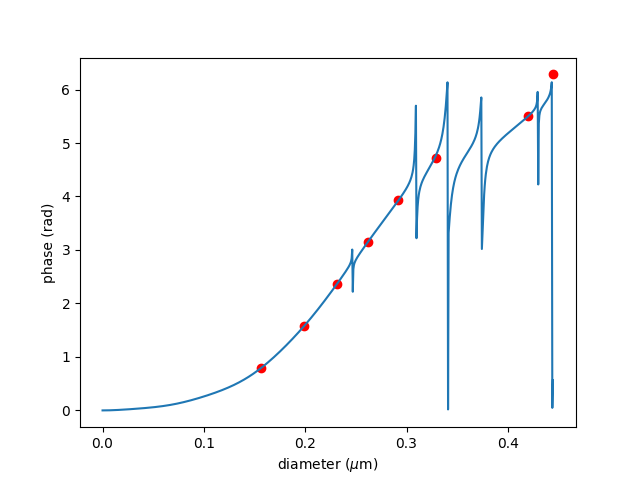

Text(0, 0.5, 'phase (rad)')

In [19]:
#Let's check the selection of phase and diameters 
diamsel = np.unique(diam_mat) 
phasesel = binarray[np.unique(newphas) ]

#print(diamsel.shape)
#print(phasesel.shape)

fig = plt.figure() 
plt.plot(dvar_cut, phas_cut)
plt.scatter(diamsel, phasesel, color='red')
plt.xlabel('diameter ($\mu$m)')
plt.ylabel('phase (rad)')

The number of levels after printing is 8.


<IPython.core.display.Javascript object>


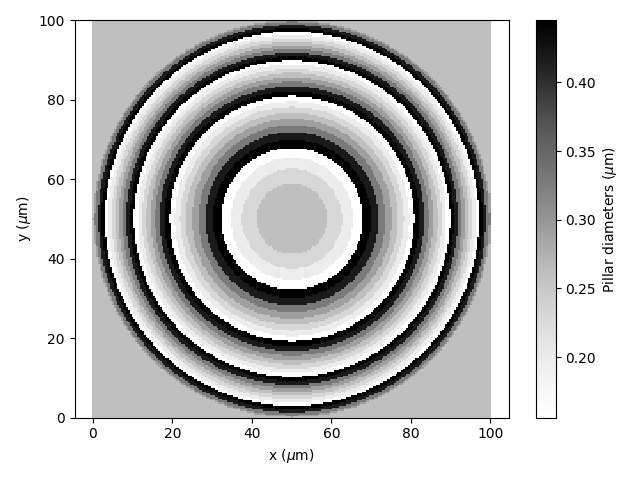

In [13]:
###Let's inspect the map of the diameter of the cylinders
#clip the matrix of values within a range  
dvarx = np.clip(diam_mat,0.1,p*0.9 )

#when clipping, we might be cutting some levels (so, the actual nr of levels is)
print("The number of levels after printing is " +str(len(np.unique(dvarx))) + ".")

#dvarx = diam_mat

#create the vectors for xsiz and ysiz, with npix 
xc1 = np.linspace(0, xsiz, npix)
yc1 = np.linspace(0, ysiz, npix)
(xc, yc) = np.meshgrid(xc1,yc1)
    
plt.figure()
plt.axis('equal')
plt.pcolormesh(xc,yc,dvarx, cmap=plt.get_cmap("Greys"))
plt.xlabel('x ($\mu$m)')
plt.ylabel('y ($\mu$m)')
plt.colorbar(label='Pillar diameters ($\mu$m)')
plt.tight_layout()

In [14]:
###Transform the phase profile into a metasurface mask 

import pyMOE.metas  as metas

p = 0.445 #periodicity between pillars in um 
pixelx = p 
pixely = p 
diam_mat = dvarx 
cellname = "TOP" #name of the gds cell 
outfile  = "fresnel_metasurface_pillars_selection.gds"

moe.metas.metasurface_pillars( xsiz, ysiz, pixelx, pixely, p, diam_mat,cellname , outfile, tolerance=1e-3 ) 


Created the metasurface mask in the file fresnel_metasurface_pillars_selection.gds


## Extra: merge layers in .gds metasurface file

In [15]:
#takes about 55min, reduces the previous > 1GB file into <15 MB 
import pyMOE.gds_klops as gdsops

#take inputfile as previous outfile  (fresnel_metasurface_pillars.gds)
inputfile = outfile
outputfile = "fresnel_metasurface_pillars_merged.gds"
layer = int(0)
datatype = int(0)

moe.gdsops.merge_layer(inputfile, cellname, layer, datatype ,outputfile )

Merged layers in fresnel_metasurface_pillars_merged.gds
